In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

# Задание 1.
Обучить полносвязную модель на MNIST

In [ ]:
dataset = datasets.MNIST('.', download=True)

In [ ]:
dataset.data.size()

torch.Size([60000, 28, 28])

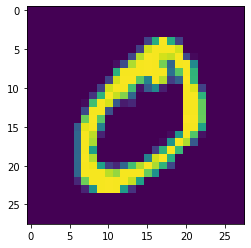

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dataset.data[1])
plt.show()

In [ ]:
# создание архитектуры модели
class LinearModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)  # слой 1
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)  # cлой 2
    self.linear3 = nn.Linear(hidden_dim, output_dim)  # cлой 3
    self.do1 = nn.Dropout(dropout_p)  # зануление нейронов между 1 и 2 слоем
    self.do2 = nn.Dropout(dropout_p)  # зануление нейронов между 2 и 3 слоем
    self.activation = nn.ReLU()  # ф-ия активации
  
  def forward(self,x):
    x = self.do1(self.activation(self.linear1(x)))
    x = self.do2(self.activation(self.linear2(x)))
    return self.linear3(x)

In [ ]:
# ф-ия обработки батчей
def collate_fn(data: list):
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1), 
      'target': target
      }

In [ ]:
# задание гиперпараметров
input_dim = 28 * 28  # 784
hidden_dim = 256 + 128
output_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128 + 172

In [ ]:
model = LinearModel(input_dim, hidden_dim, output_dim).to(device)
optim_rms = torch.optim.RMSprop(model.parameters())  # формируем оптимизатор
optim_adam = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()  # определение ф-ии потерь

In [ ]:
# процесс обучения
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last=True,  # выкидывает последний батч если он меньше заданного размера
                          )
  for i, batch in enumerate(dataloader):
    optim_rms.zero_grad()
    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device).long())
    loss.backward() # расчитывает градиенты
    optim_rms.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')  # сохранение чекпоинта модели

epoch: 0, step: 0, loss: 2.303877115249634
epoch: 1, step: 0, loss: 0.16502483189105988
epoch: 2, step: 0, loss: 0.1364763081073761
epoch: 3, step: 0, loss: 0.16865627467632294
epoch: 4, step: 0, loss: 0.2164524644613266
epoch: 5, step: 0, loss: 0.12518177926540375
epoch: 6, step: 0, loss: 0.12044809013605118
epoch: 7, step: 0, loss: 0.062001921236515045
epoch: 8, step: 0, loss: 0.1187746524810791
epoch: 9, step: 0, loss: 0.06152720004320145


In [ ]:
# процесс обучения
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last=True,  # выкидывает последний батч если он меньше заданного размера
                          )
  for i, batch in enumerate(dataloader):
    optim_adam.zero_grad()
    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device).long())
    loss.backward() # расчитывает градиенты
    optim_adam.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')  # сохранение чекпоинта модели

epoch: 0, step: 0, loss: 0.05258622765541077
epoch: 1, step: 0, loss: 0.027443373575806618
epoch: 2, step: 0, loss: 0.04527699202299118
epoch: 3, step: 0, loss: 0.0401105135679245
epoch: 4, step: 0, loss: 0.02968071587383747
epoch: 5, step: 0, loss: 0.01127178966999054
epoch: 6, step: 0, loss: 0.006737405434250832
epoch: 7, step: 0, loss: 0.019145546481013298
epoch: 8, step: 0, loss: 0.007881798781454563
epoch: 9, step: 0, loss: 0.013595941476523876


**Вывод:** оптимизатор Adam в сравнении с RMSProp показывает показывает ошибку обучения на порядок ниже

# Задание 2.
Обучить глубокую сверточную сеть на MNIST

In [ ]:
# создание архитектуры модели
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, 
                           kernel_size=5, padding=2, stride=2)  # свертка (уменш.в 2раза)
    self.bn1 = nn.BatchNorm2d(hidden_ch) # нормализация
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch,
                           kernel_size=3, padding=1)  # свертка
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 2,
                           kernel_size=3, padding=1)  # свертка
    self.bn3 = nn.BatchNorm2d(2)
    self.linear3 = nn.Linear(2 * 14 * 14, output_dim)  # cлой классификации
    self.do1 = nn.Dropout(dropout_p)  # зануление нейронов между 1 и 2 слоем
    self.do2 = nn.Dropout(dropout_p)  # зануление нейронов между 2 и 3 слоем
    self.activation = nn.ReLU()  # ф-ия активации
     

  def forward(self,x):
    x = self.do1(self.activation(self.bn1(self.conv1(x))))
    x = self.do2(self.activation(self.bn2(self.conv2(x))))
    x = self.activation(self.bn3(self.conv3(x)))  # B * 12 * 12
    
    return self.linear3(x.view(x.size(0), -1))

In [ ]:
# ф-ия обработки батчей
def collate_fn_conv(data: list):
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), 
      'target': target.long()
      }

In [ ]:
# задание гиперпараметров
input_ch = 1  # 784
hidden_ch = 128
output_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
model_conv = ConvModel(input_ch, hidden_ch, output_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())  # формируем оптимизатор
loss_func = nn.CrossEntropyLoss()  # определение ф-ии потерь

In [ ]:
# процесс обучения
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last=True,  # выкидывает последний батч если он меьше заданного размера
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    loss.backward() # расчитывает градиенты
    optim.step()
    if i % 400 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model_conv.state_dict(), f'./chkpt_conv_{epoch}.pth')  # сохранение чекпойинта модели

epoch: 0, step: 0, loss: 0.02051735110580921
epoch: 0, step: 400, loss: 0.05650608241558075
epoch: 1, step: 0, loss: 0.022455455735325813
epoch: 1, step: 400, loss: 0.017734207212924957
epoch: 2, step: 0, loss: 0.00926903821527958
epoch: 2, step: 400, loss: 0.003949418198317289
epoch: 3, step: 0, loss: 0.02523891068994999
epoch: 3, step: 400, loss: 0.004886065609753132
epoch: 4, step: 0, loss: 0.010927299968898296
epoch: 4, step: 400, loss: 0.0038823499344289303
epoch: 5, step: 0, loss: 0.0013564538676291704
epoch: 5, step: 400, loss: 0.010924956761300564
epoch: 6, step: 0, loss: 0.01026804931461811
epoch: 6, step: 400, loss: 0.012806103564798832
epoch: 7, step: 0, loss: 0.007155256811529398
epoch: 7, step: 400, loss: 0.009901256300508976
epoch: 8, step: 0, loss: 0.003924274817109108
epoch: 8, step: 400, loss: 0.005915656685829163
epoch: 9, step: 0, loss: 0.010234196670353413
epoch: 9, step: 400, loss: 0.011571325361728668


In [ ]:
# создание архитектуры модели (использование пулинга)
class ConvModelV2(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, 
                           kernel_size=5, padding=2, stride=1)  # свертка (уменш.в 2раза)
    self.pool1 = nn.MaxPool2d(2,2)
    self.bn1 = nn.BatchNorm2d(hidden_ch) # нормализация
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch,
                           kernel_size=3, padding=1)  # свертка
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 2,
                           kernel_size=3, padding=1)  # свертка
    self.bn3 = nn.BatchNorm2d(2)
    self.linear3 = nn.Linear(2 * 14 * 14, output_dim)  # cлой классификации
    self.do1 = nn.Dropout(dropout_p)  # зануление нейронов между 1 и 2 слоем
    self.do2 = nn.Dropout(dropout_p)  # зануление нейронов между 2 и 3 слоем
    self.activation = nn.ReLU()  # ф-ия активации
     

  def forward(self,x):
    x = self.do1(self.activation(self.bn1(self.pool1(self.conv1(x)))))
    x = self.do2(self.activation(self.bn2(self.conv2(x))))
    x = self.activation(self.bn3(self.conv3(x)))  # B * 12 * 12
    
    return self.linear3(x.view(x.size(0), -1))

In [ ]:
model_conv_v2 = ConvModelV2(input_ch, hidden_ch, output_dim).to(device)
optim = torch.optim.Adam(model_conv_v2.parameters())  # формируем оптимизатор
loss_func = nn.CrossEntropyLoss()  # определение ф-ии потерь

In [ ]:
# процесс обучения
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last=True,  # выкидывает последний батч если он меьше заданного размера
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    predict = model_conv_v2(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    loss.backward() # расчитывает градиенты
    optim.step()
    if i % 400 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model_conv_v2.state_dict(), f'./chkpt_conv_{epoch}.pth')  # сохранение чекпойинта модели

epoch: 0, step: 0, loss: 2.371856212615967
epoch: 0, step: 400, loss: 0.05620186775922775
epoch: 1, step: 0, loss: 0.06407012045383453
epoch: 1, step: 400, loss: 0.0648491159081459
epoch: 2, step: 0, loss: 0.034042321145534515
epoch: 2, step: 400, loss: 0.05642253905534744
epoch: 3, step: 0, loss: 0.008731827139854431
epoch: 3, step: 400, loss: 0.021205900236964226
epoch: 4, step: 0, loss: 0.049343291670084
epoch: 4, step: 400, loss: 0.015877239406108856
epoch: 5, step: 0, loss: 0.007207996211946011
epoch: 5, step: 400, loss: 0.04810795187950134
epoch: 6, step: 0, loss: 0.010293238796293736
epoch: 6, step: 400, loss: 0.015594851225614548
epoch: 7, step: 0, loss: 0.017290085554122925
epoch: 7, step: 400, loss: 0.00932107213884592
epoch: 8, step: 0, loss: 0.005736505147069693
epoch: 8, step: 400, loss: 0.006375493947416544
epoch: 9, step: 0, loss: 0.007236498408019543
epoch: 9, step: 400, loss: 0.015202701091766357


**Вывод:** использование пулинга по максимальному значению для уменьшения размерности вместо уменьшения размерности с помощью свертки дает более позднюю сходимость модели